This notebook analyzes the difference between the empirical and analytical standard deviation of the position found in experiments. 
Conclusion: The relative error scales with the inverse of the square root of the time, i.e.
$$\frac{\left|\sigma_{\text{ana.}}(t) - \sigma_{\text{emp.}}(t)\right|}{\langle X(t) \rangle} \propto \frac{1}{\sqrt{t}}$$

In [2]:
from experiments import *
from translocation_models import *
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress

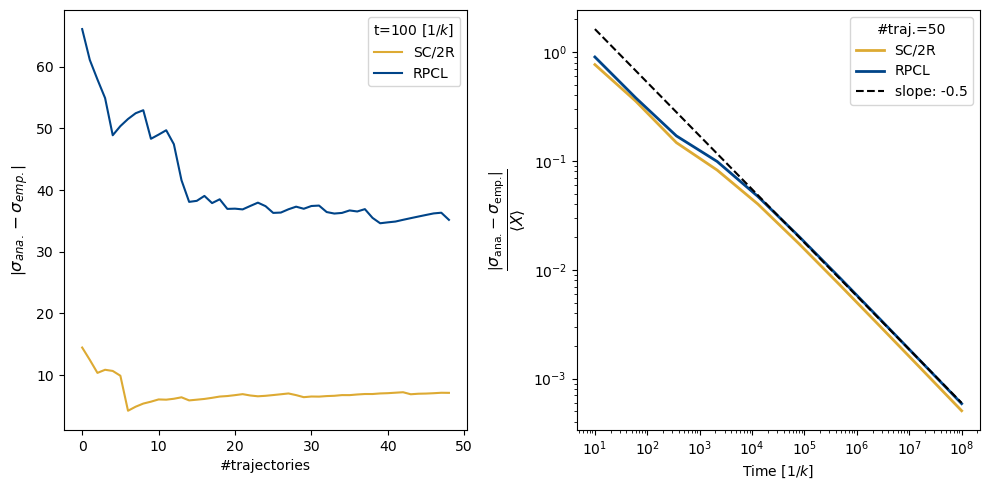

In [4]:
sc2r = SC2R()
rpcl = RPCL()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
yellow = '#DDAA33'
blue = '#004488'

# Convergence emp. vs ana. std depending on the number of simulations
time = float(100)
n_simulations = 50

models = [sc2r, rpcl]
names = ['SC/2R', 'RPCL']
colors = [yellow, blue]
for model, name, color in zip(models, names, colors):
    analytical_std = (model.analytical_attribute_stats('position', time))['std'].iat[0]
    trajectories = model.gillespie(max_time=time, n_simulations=n_simulations, 
                                   cumulative_sums='position')
    end_positions = [trajectory['position'].iat[-1] for trajectory in trajectories]
    iterative_empirical_std = []
    for i in range(1, len(end_positions)):
        iterative_empirical_std.append(np.std(end_positions[:i]))
    iterative_empirical_std = np.array(iterative_empirical_std)
    axs[0].plot(np.abs(iterative_empirical_std-analytical_std), label=name,
                color=color)
axs[0].set_xlabel('#trajectories')
axs[0].set_ylabel(r'$\left|\sigma_{ana.}-\sigma_{emp.}\right|$')
axs[0].yaxis.label.set_size(12)
axs[0].legend(title='t=' + str(round(time)) + r' [$1/k$]')

# Scaling of the relative std error with time
times = np.logspace(1, 8, num=10)
n_simulations = 50
sc2r_analytical_stats = sc2r.analytical_attribute_stats('position', times)
sc2r_empirical_stats, _ = sc2r.empirical_attribute_stats('position', times, n_simulations=n_simulations)
rpcl_analytical_stats = rpcl.analytical_attribute_stats('position', times)
rpcl_empirical_stats, _ = rpcl.empirical_attribute_stats('position', times, n_simulations=n_simulations)

linewidth = 2
axs[1].plot(
    times, 
    ((sc2r_empirical_stats['std'] - sc2r_analytical_stats['std']).abs() 
     / sc2r_analytical_stats['mean']),
    label='SC/2R',
    color=yellow,
    linewidth=linewidth)
axs[1].plot(
    times, 
    ((rpcl_empirical_stats['std'] - rpcl_analytical_stats['std']).abs() 
     / rpcl_analytical_stats['mean']),
    label='RPCL',
    color=blue,
    linewidth=linewidth)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
# linear fit on log-log plot
x = times[4:]
y = ((rpcl_empirical_stats['std'] - rpcl_analytical_stats['std']).abs() 
     / rpcl_analytical_stats['mean'])[4:]
slope, intercept, r_value, p_value, std_err = linregress(np.log(x), np.log(y))
axs[1].plot(times, np.exp(intercept) * times**slope, label=f'slope: {slope:.1f}',
        color='black', linestyle='--')
axs[1].set_xlabel(r'Time [$1/k$]')
axs[1].set_ylabel(r'$\frac{\left|\sigma_{\text{ana.}} - \sigma_{\text{emp.}}\right|}{\langle X \rangle}$')
# fontsize
axs[1].yaxis.label.set_size(16)
axs[1].legend(title='#traj.=' + str(n_simulations))

plt.tight_layout()
plt.savefig('images/std_error.pdf')
plt.show()
